# Proyecto de Clasificación: Predicción de Ingresos Anuales
**Análisis Exploratorio, Feature Engineering y Modelado con Scikit-Learn y
XGBoost*

## **Objetivo del Proyecto**

El presente notebook detalla el proceso de construcción de un modelo de Machine
Learning para predecir si un individuo tiene ingresos anuales superiores a 50,000
dólares, utilizando el conjunto de datos "Adult Income" del censo de 1994.
Este proyecto está diseñado como una demostración técnica para un portafolio de
Data Science, mostrando un flujo de trabajo completo que abarca desde la limpieza y
el análisis exploratorio de datos (EDA) hasta la ingeniería de características, el
entrenamiento de modelos, la optimización de hiperparámetros y la evaluación
rigurosa del rendimiento.  

## **Hipótesis Inicial**

La primcipal hipótesis es que factores socioeconómicos como el **nivel educativo
(`education_num`)**, el **estado civil (`marital_status`)**, las **ganancias de
capital (`capital_gain`)** y el **tipo de ocupación (`occupation`)** son
predictores clave del nivel de ingresos. Se espera que el principal desafío técnico
sea el desbalance de clases en la variable objetivo, lo que requerirá estrategias
específicas para construir un modelo robusto y justo

#  Carga y Preparación Inicial de Datos

Comenzamos importando las librerías fundamentales para el análisis y la
manipulación de datos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
! pip install ucimlrepo

Para obtener los datos, utilizamos la librería `ucimlrepo`, que facilita la
descarga directa de datasets desde el Repositorio de Machine Learning de UC Irvine.

In [3]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

# Descargar el dataset por su ID (Adult Income es el ID 2)
adult = fetch_ucirepo(id=2)

# Obtener los datos como DataFrames de Pandas
X = adult.data.features
y = adult.data.targets

# Combinarlos si quieres el dataset completo
df_origin = pd.concat([X, y], axis=1)
print(df_origin.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB
None


Como buena práctica estandarizamos los nombres de las columnas a un formato
consistente (snake_case) para facilitar su manipulación

In [4]:
# Reemplazar guiones medios por guiones bajos
df_origin.columns = [col.replace('-', '_').replace('.', '_') for col in df_origin.columns]
# Verificar los nuevos nombres
print(df_origin.columns)

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income'],
      dtype='object')


In [5]:
df=df_origin.copy()

# Análisis Exploratorio de Datos (EDA) y Limpieza


En esta fase, investigamos la estructura y calidad de los datos para identificar
patrones, anomalías y oportunidades de feature engineering.

In [6]:
df.sample(n=100)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
29826,36,Private,90159,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,32,United-States,>50K
36804,41,Private,205670,HS-grad,9,Divorced,Adm-clerical,Unmarried,Black,Female,0,0,40,United-States,<=50K.
41552,26,Private,186168,Bachelors,13,Never-married,Exec-managerial,Own-child,White,Female,0,0,40,United-States,<=50K.
11079,35,Private,150057,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
16306,27,Private,169117,HS-grad,9,Married-civ-spouse,Adm-clerical,Wife,Black,Female,0,1887,40,United-States,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23899,47,Private,185399,HS-grad,9,Married-civ-spouse,Other-service,Wife,White,Female,0,0,38,United-States,<=50K
42337,27,Private,446947,Bachelors,13,Never-married,Adm-clerical,Unmarried,Black,Female,0,0,55,United-States,<=50K.
38617,21,Private,449101,HS-grad,9,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States,<=50K.
5920,22,Private,187538,10th,6,Separated,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education_num   48842 non-null  int64 
 5   marital_status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital_gain    48842 non-null  int64 
 11  capital_loss    48842 non-null  int64 
 12  hours_per_week  48842 non-null  int64 
 13  native_country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [8]:
df.shape

(48842, 15)

#  Diccionario de Datos y Selección de Features


El dataset contiene 48,842 registros y 15 columnas. A continuación se presenta un
diccionario de datos y las decisiones iniciales de selección de características.

| Columna | Descripción | Tipo | Decisión | Razón |
| :--- | :--- | :--- | :--- | :--- |
| `age` | Edad del individuo | Numérica | **Mantener** | Variable demográfica fundamental. |
| `workclass` | Tipo de empleo (privado, gobierno, etc.) | Categórica | **Mantener** | Potencial predictor del nivel de ingresos. |
| `fnlwgt` | Ponderador de muestreo final | Numérica | **Eliminar** | Irrelevante para la predicción individual. |
| `education` | Nivel educativo (texto) | Categórica | **Eliminar** | Redundante con `education_num`. |
| `education_num` | Nivel educativo (numérico) | Numérica | **Mantener** | Representación ordinal y numérica de la educación. |
| `marital_status`| Estado civil | Categórica | **Mantener** | Fuerte indicador socioeconómico. |
| `occupation` | Ocupación | Categórica | **Mantener** | Clave para determinar el potencial de ingresos. |
| `relationship` | Relación familiar | Categórica | **Mantener** | Aporta contexto sobre la estructura del hogar. |
| `race` | Raza | Categórica | **Mantener** | Variable demográfica importante. |
| `sex` | Sexo | Categórica | **Mantener** | Variable demográfica importante. |
| `capital_gain` | Ganancias de capital | Numérica | **Mantener** | Indicador directo de riqueza/inversión. |
| `capital_loss` | Pérdidas de capital | Numérica | **Mantener** | Indicador directo de riqueza/inversión. |
| `hours_per_week`| Horas trabajadas por semana | Numérica | **Mantener** | Fuerte correlación con el esfuerzo laboral. |
| `native_country`| País de origen | Categórica | **Mantener** | Aporta contexto sobre el origen del individuo. |
| `income` | **Variable Objetivo** | Categórica | **Mantener** | Indica si los ingresos son >50K o <=50K. |

# Eliminamos las columnas para proceder con la limpieza

En este caso eliminamos la columna education por ser redundante con la columna education.num. Por otro lado eliminamos la columna fnlwgt ya que es un ponderados y no nos es relevante para este caso práctico.

In [9]:
df.drop(['fnlwgt', 'education'],inplace=True, axis=1)


In [10]:
df.shape

(48842, 13)

# Limpieza de Datos: Valores Nulos y Atípicos

## Verificamos los valores únicos de cada columna

In [11]:
df['age'].unique()

array([39, 50, 38, 53, 28, 37, 49, 52, 31, 42, 30, 23, 32, 40, 34, 25, 43,
       54, 35, 59, 56, 19, 20, 45, 22, 48, 21, 24, 57, 44, 41, 29, 18, 47,
       46, 36, 79, 27, 67, 33, 76, 17, 55, 61, 70, 64, 71, 68, 66, 51, 58,
       26, 60, 90, 75, 65, 77, 62, 63, 80, 72, 74, 69, 73, 81, 78, 88, 82,
       83, 84, 85, 86, 87, 89])

In [12]:
df['workclass'].unique()

array(['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov',
       'Local-gov', '?', 'Self-emp-inc', 'Without-pay', 'Never-worked',
       nan], dtype=object)

In [13]:
df['education_num'].unique()

array([13,  9,  7, 14,  5, 10, 12, 11,  4, 16, 15,  3,  6,  2,  1,  8])

In [14]:
df['marital_status'].unique()

array(['Never-married', 'Married-civ-spouse', 'Divorced',
       'Married-spouse-absent', 'Separated', 'Married-AF-spouse',
       'Widowed'], dtype=object)

In [15]:
df['occupation'].unique()

array(['Adm-clerical', 'Exec-managerial', 'Handlers-cleaners',
       'Prof-specialty', 'Other-service', 'Sales', 'Craft-repair',
       'Transport-moving', 'Farming-fishing', 'Machine-op-inspct',
       'Tech-support', '?', 'Protective-serv', 'Armed-Forces',
       'Priv-house-serv', nan], dtype=object)

In [16]:
df['relationship'].unique()

array(['Not-in-family', 'Husband', 'Wife', 'Own-child', 'Unmarried',
       'Other-relative'], dtype=object)

In [17]:
df['race'].unique()

array(['White', 'Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo',
       'Other'], dtype=object)

In [18]:
df['sex'].unique()

array(['Male', 'Female'], dtype=object)

In [19]:
df['capital_gain'].unique()

array([ 2174,     0, 14084,  5178,  5013,  2407, 14344, 15024,  7688,
       34095,  4064,  4386,  7298,  1409,  3674,  1055,  3464,  2050,
        2176,   594, 20051,  6849,  4101,  1111,  8614,  3411,  2597,
       25236,  4650,  9386,  2463,  3103, 10605,  2964,  3325,  2580,
        3471,  4865, 99999,  6514,  1471,  2329,  2105,  2885, 25124,
       10520,  2202,  2961, 27828,  6767,  2228,  1506, 13550,  2635,
        5556,  4787,  3781,  3137,  3818,  3942,   914,   401,  2829,
        2977,  4934,  2062,  2354,  5455, 15020,  1424,  3273, 22040,
        4416,  3908, 10566,   991,  4931,  1086,  7430,  6497,   114,
        7896,  2346,  3418,  3432,  2907,  1151,  2414,  2290, 15831,
       41310,  4508,  2538,  3456,  6418,  1848,  3887,  5721,  9562,
        1455,  2036,  1831, 11678,  2936,  2993,  7443,  6360,  1797,
        1173,  4687,  6723,  2009,  6097,  2653,  1639, 18481,  7978,
        2387,  5060,  1264,  7262,  1731,  6612])

In [20]:
df['capital_loss'].unique()

array([   0, 2042, 1408, 1902, 1573, 1887, 1719, 1762, 1564, 2179, 1816,
       1980, 1977, 1876, 1340, 2206, 1741, 1485, 2339, 2415, 1380, 1721,
       2051, 2377, 1669, 2352, 1672,  653, 2392, 1504, 2001, 1590, 1651,
       1628, 1848, 1740, 2002, 1579, 2258, 1602,  419, 2547, 2174, 2205,
       1726, 2444, 1138, 2238,  625,  213, 1539,  880, 1668, 1092, 1594,
       3004, 2231, 1844,  810, 2824, 2559, 2057, 1974,  974, 2149, 1825,
       1735, 1258, 2129, 2603, 2282,  323, 4356, 2246, 1617, 1648, 2489,
       3770, 1755, 3683, 2267, 2080, 2457,  155, 3900, 2201, 1944, 2467,
       2163, 2754, 2472, 1411, 1429, 3175, 1510, 1870, 1911, 2465, 1421])

In [21]:
df['hours_per_week'].unique()

array([40, 13, 16, 45, 50, 80, 30, 35, 60, 20, 52, 44, 15, 25, 38, 43, 55,
       48, 58, 32, 70,  2, 22, 56, 41, 28, 36, 24, 46, 42, 12, 65,  1, 10,
       34, 75, 98, 33, 54,  8,  6, 64, 19, 18, 72,  5,  9, 47, 37, 21, 26,
       14,  4, 59,  7, 99, 53, 39, 62, 57, 78, 90, 66, 11, 49, 84,  3, 17,
       68, 27, 85, 31, 51, 77, 63, 23, 87, 88, 73, 89, 97, 94, 29, 96, 67,
       82, 86, 91, 81, 76, 92, 61, 74, 95, 79, 69])

In [22]:
df['native_country'].unique()

array(['United-States', 'Cuba', 'Jamaica', 'India', '?', 'Mexico',
       'South', 'Puerto-Rico', 'Honduras', 'England', 'Canada', 'Germany',
       'Iran', 'Philippines', 'Italy', 'Poland', 'Columbia', 'Cambodia',
       'Thailand', 'Ecuador', 'Laos', 'Taiwan', 'Haiti', 'Portugal',
       'Dominican-Republic', 'El-Salvador', 'France', 'Guatemala',
       'China', 'Japan', 'Yugoslavia', 'Peru',
       'Outlying-US(Guam-USVI-etc)', 'Scotland', 'Trinadad&Tobago',
       'Greece', 'Nicaragua', 'Vietnam', 'Hong', 'Ireland', 'Hungary',
       'Holand-Netherlands', nan], dtype=object)

In [23]:
df['income'].unique()

array(['<=50K', '>50K', '<=50K.', '>50K.'], dtype=object)

El primer paso en la limpieza es identificar y manejar valores nulos. A simple
vista, `df.info()` mostró valores faltantes en `workclass`, `occupation` y
`native_country`. Sin embargo, una inspección más detallada de los valores únicos
revela que los datos faltantes también están representados por el string `'?'`.

In [24]:
print((df.eq('?').sum()/(df.shape[0]))*100)

age               0.000000
workclass         3.759060
education_num     0.000000
marital_status    0.000000
occupation        3.773392
relationship      0.000000
race              0.000000
sex               0.000000
capital_gain      0.000000
capital_loss      0.000000
hours_per_week    0.000000
native_country    1.193645
income            0.000000
dtype: float64


## Tratamiento de valores nulos

Dado que el porcentaje de filas con valores `'?'` es bajo (inferior al 4% en el
peor de los casos), se opta por la eliminación de estos registros. Esta es una
estrategia simple y efectiva que evita introducir sesgos a través de la imputación,
sin una pérdida significativa de información.

In [25]:
df= df[~df['workclass'].isin(['?'])]

In [26]:
df = df[~df['occupation'].isin(['?'])]

In [27]:
df = df[~df['native_country'].isin(['?'])]

In [28]:
df['workclass'].value_counts()#control de que se eliimaron correctamente '?'

,count
workclass,
Private,33496
Self-emp-not-inc,3820
Local-gov,3110
State-gov,1962
Self-emp-inc,1653
Federal-gov,1415
Without-pay,21
Never-worked,3


In [29]:
df['occupation'].value_counts()#control de que se eliimaron correctamente '?'


,count
occupation,
Prof-specialty,6070
Craft-repair,6043
Exec-managerial,6012
Adm-clerical,5562
Sales,5438
Other-service,4840
Machine-op-inspct,2986
Transport-moving,2330
Handlers-cleaners,2052


In [30]:
df['native_country'].value_counts()#control de que se eliimaron correctamente '?'

,count
native_country,
United-States,42166
Mexico,918
Philippines,285
Germany,197
Puerto-Rico,179
Canada,168
India,151
El-Salvador,149
Cuba,135


## Normalización de target

Adicionalmente, se observa que la variable objetivo `income` contiene valores
inconsistentes (`'<=50K.'` y `'>50K.'` con un punto al final), los cuales deben ser
normalizados.
Calculamos el porcentaje de valores `'?'` para decidir la estrategia de manejo:

In [31]:
df['income'].unique()

array(['<=50K', '>50K', '<=50K.', '>50K.'], dtype=object)

In [32]:
df['income'] = df['income'].str.replace('.','', regex=False).str.strip()

In [33]:
df['income'].unique()

array(['<=50K', '>50K'], dtype=object)

## Codificación de variable target

In [34]:
df['income'] = df['income'].replace({'<=50K': 0, '>50K': 1})

/tmp/ipython-input-2921650987.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['income'] = df['income'].replace({'<=50K': 0, '>50K': 1})


In [35]:
df['income'].unique()

array([0, 1])

# Análisis de las variables numéricas

## Resumen estadístico
Se aplicará un describe incorporando rango y sesgo para un analisis rápido de la distibución de las diferentes clases

In [36]:
resumen = df.describe()
rangos = df.max(numeric_only=True)-df.min(numeric_only=True)
sesgos = df.mean(numeric_only=True)-df.median(numeric_only=True)
rango_df = pd.DataFrame(rangos, columns=['Rango']).T
sesgos_df = pd.DataFrame(sesgos, columns=['Sesgo']).T

resumen_conca = pd.concat([resumen,rango_df,sesgos_df])
resumen_conca.round(3)

,age,education_num,capital_gain,capital_loss,hours_per_week,income
count,46443.000,46443.000,46443.000,46443.000,46443.000,46443.000
mean,38.553,10.104,1088.466,88.207,40.742,0.244
std,13.390,2.556,7469.003,403.876,12.160,0.430
min,17.000,1.000,0.000,0.000,1.000,0.000
25%,28.000,9.000,0.000,0.000,40.000,0.000
50%,37.000,10.000,0.000,0.000,40.000,0.000
75%,47.000,13.000,0.000,0.000,45.000,0.000
max,90.000,16.000,99999.000,4356.000,99.000,1.000
Rango,73.000,15.000,99999.000,4356.000,98.000,1.000
Sesgo,1.553,0.104,1088.466,88.207,0.742,0.244


**Observaciones Clave:**- **`capital_gain` y `capital_loss`**: Ambas variables son extremadamente
asimétricas. La mediana (percentil 50) es 0, pero el valor máximo es 99,999 para
`capital_gain`. Esto indica que la mayoría de los individuos no reportan ganancias
o pérdidas de capital, pero un pequeño número tiene valores muy altos (outliers).
Este comportamiento `zero-inflated` y de cola larga requerirá un escalado robusto.- **`age`**: Presenta una ligera asimetría positiva, con una edad media de ~38.5
años.- **`hours_per_week`**: La mayoría de las personas trabajan alrededor de 40 horas,
pero existen valores extremos que llegan hasta 99 horas.

## Análisis gráfico de variables

In [37]:
variables_numericas= df.select_dtypes(include=['int']).columns
variables_numericas

Index(['age', 'education_num', 'capital_gain', 'capital_loss',
       'hours_per_week', 'income'],
      dtype='object')

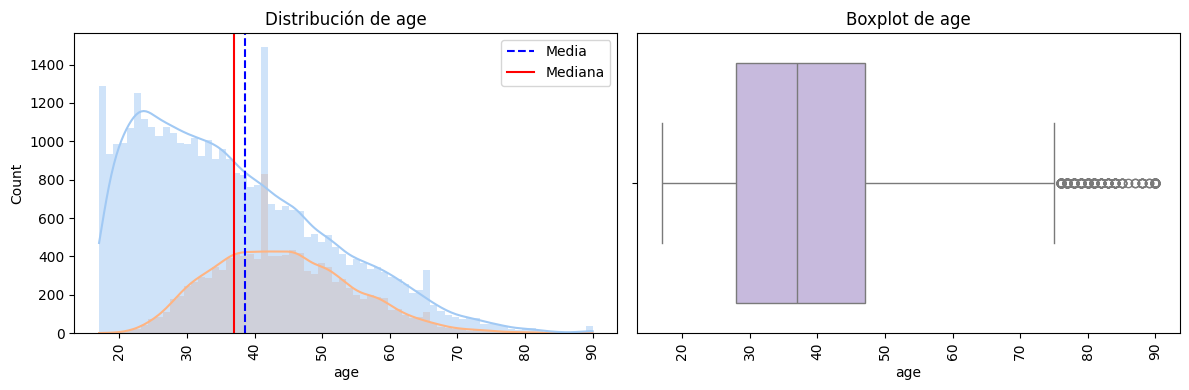

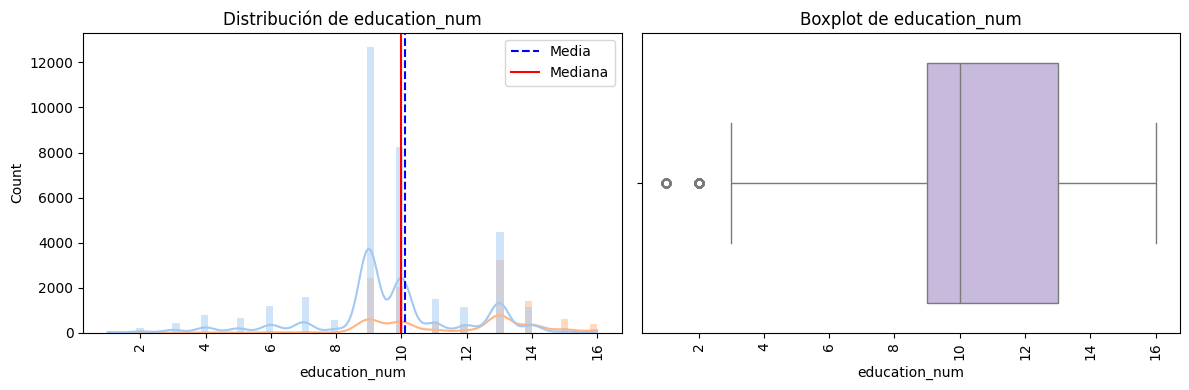

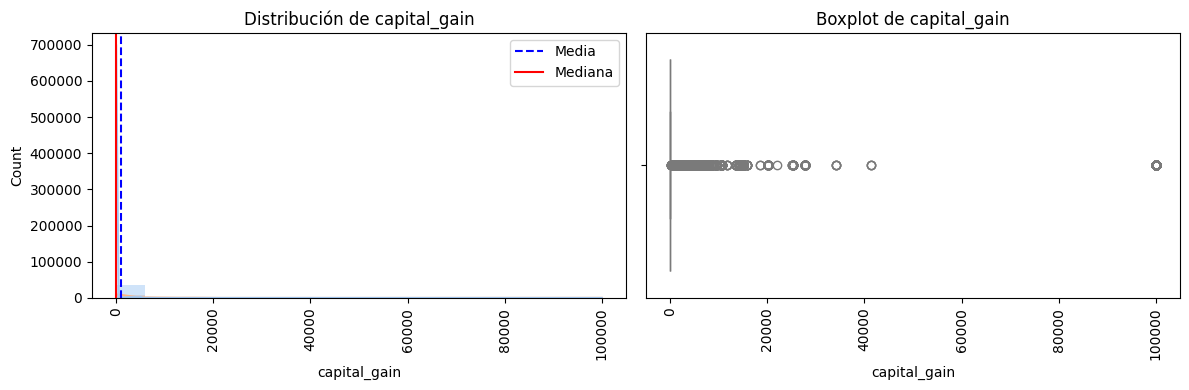

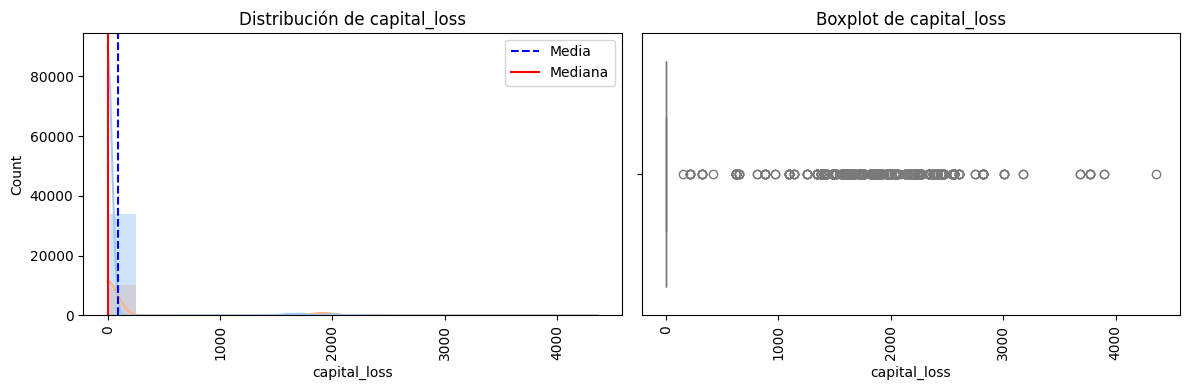

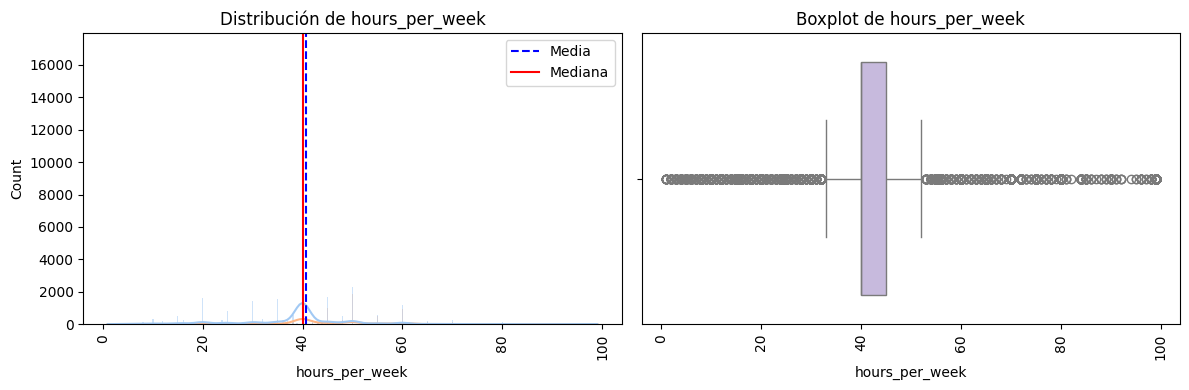

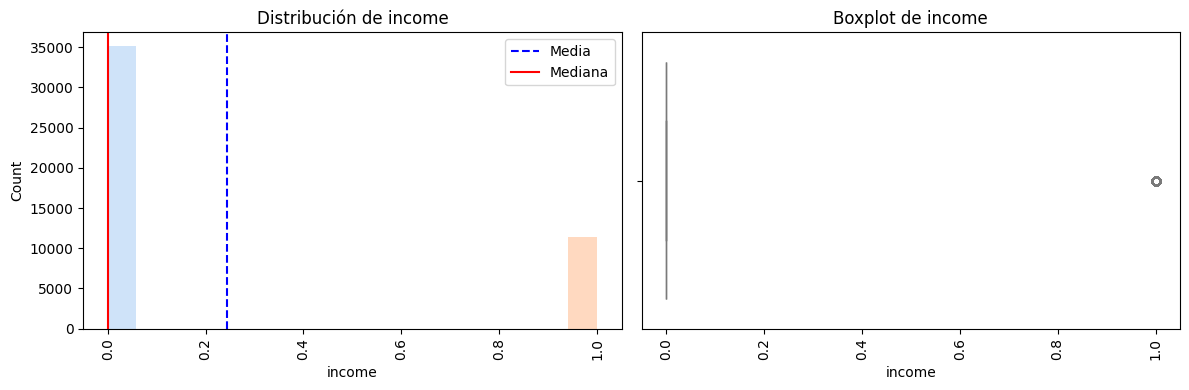

In [38]:
n_cols = 2
n_rows = 4
for columna in variables_numericas:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    # Histograma con KDE
    sns.histplot(x=columna, data=df, kde=True, linewidth=0, hue='income', palette='pastel', ax=ax[0])
    ax[0].axvline(x=df[columna].mean(), color='blue', linestyle='--', label='Media')
    ax[0].axvline(x=df[columna].median(), color='red', linestyle='-', label='Mediana')
    ax[0].set_title(f'Distribución de {columna}')
    ax[0].tick_params(axis='x', rotation=90)
    ax[0].legend()

    # Boxplot
    sns.boxplot(x=columna, data=df, ax=ax[1], color= '#C5B4E3')
    ax[1].set_title(f'Boxplot de {columna}')
    ax[1].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

**Conclusión sobre Variables Numéricas:** Las visualizaciones confirman la
asimetría y la presencia de outliers significativos. Estos outliers son
representativos de la población (ej. individuos con altas ganancias de capital) y
no deben ser eliminados. Para asegurar que nuestro modelo no sea sensible a estos
valores extremos, se utilizará **`RobustScaler`** durante el preprocesamiento, ya
que este método escala los datos utilizando el rango intercuartílico, siendo menos
susceptible a outliers que otros escaladores.

# Análisis de Variables Categóricas y Feature Engineering

## Resumen estadístico:
comenzaremos con un describe


In [39]:
df.describe(include=['object'])

,workclass,marital_status,occupation,relationship,race,sex,native_country
count,45480,46443,45477,46443,46443,46443,46169
unique,8,7,14,6,5,2,41
top,Private,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States
freq,33496,21468,6070,18986,39879,31240,42166


El análisis revela una alta cardinalidad en `occupation` (14 categorías) y
especialmente en `native_country` (41 categorías). Una alta cardinalidad puede
llevar a una dispersión de los datos y dificultar que el modelo aprenda patrones
efectivos. Para mitigar esto, se aplicará una estrategia de **agrupación de
categorías**.

## Reducción de cardinalidad

A continuación, se procede a la agrupación lógica de categorías para `workclass`,
`occupation` y `native_country`

In [40]:
# Recategorización de 'ocupation'
remplazo_workclass= {
    'Private': 'Private',
    'Self-emp-not-inc': 'Self_employed',
    'Self-emp-inc': 'Self_employed',
    'Local-gov': 'Gov',
    'State-gov': 'Gov',
    'Federal-gov': 'Gov',
    'Without-pay': 'Without_pay',
    'Never-worked': 'Never_worked'
}

df['workclass'] = df['workclass'].replace(remplazo_workclass)#remplazo de las categorias de originales por las nuevas

In [41]:
df[['workclass']].value_counts() #control de remplazo

,count
workclass,
Private,33496
Gov,6487
Self_employed,5473
Without_pay,21
Never_worked,3


In [42]:
remplazo_occupation = {
    'Exec-managerial': 'White-collar', #trabajos de oficina/profesionales
    'Prof-specialty': 'White-collar',
    'Adm-clerical': 'White-collar',
    'Tech-support': 'White-collar',

    'Craft-repair': 'Blue-collar', #trabajos manuales
    'Transport-moving': 'Blue-collar',
    'Machine-op-inspct': 'Blue-collar',
    'Handlers-cleaners': 'Blue-collar',
    'Farming-fishing': 'Blue-collar',

    'Sales': 'Service',
    'Other-service': 'Service',
    'Protective-serv': 'Service',
    'Priv-house-serv': 'Service',

    'Armed-Forces': 'Military'
}

df['occupation'] = df['occupation'].replace(remplazo_occupation)#remplazo de las categorias de originales por las nuevas

In [43]:
df[['occupation']].value_counts()#control de remplazo

,count
occupation,
White-collar,19074
Blue-collar,14896
Service,11492
Military,15


In [44]:
remplazo_native_coutry = {

    'United-States':'United-States',
    'South':'United-States',

    'Canada': 'other north american countries',
    'Outlying-US(Guam-USVI-etc)': 'other north american countries',


    'Mexico': 'Latin american/caribbean countries',
    'Dominican-Republic': 'Latin american/caribbean countries',
    'El-Salvador': 'Latin american/caribbean countries',
    'Guatemala': 'Latin american/caribbean countries',
    'Columbia': 'Latin american/caribbean countries',
    'Peru': 'Latin american/caribbean countries',
    'Cuba': 'Latin american/caribbean countries',
    'Haiti': 'Latin american/caribbean countries',
    'Ecuador': 'Latin american/caribbean countries',
    'Nicaragua': 'Latin american/caribbean countries',
    'Honduras': 'Latin american/caribbean countries',
    'Trinadad&Tobago': 'Latin american/caribbean countries',
    'Jamaica': 'Latin american/caribbean countries',
    'Puerto-Rico': 'Latin american/caribbean countries',



    'India': 'Asian countries',
    'China': 'Asian countries',
    'Philippines': 'Asian countries',
    'Japan': 'Asian countries',
    'Vietnam': 'Asian countries',
    'Thailand': 'Asian countries',
    'Taiwan': 'Asian countries',
    'Cambodia': 'Asian countries',
    'Hong': 'Asian countries',
    'Iran': 'Asian countries',
    'Laos': 'Asian countries',

    'Germany': 'European countries',
    'England': 'European countries',
    'France': 'European countries',
    'Italy': 'European countries',
    'Portugal': 'European countries',
    'Poland': 'European countries',
    'Ireland': 'European countries',
    'Scotland': 'European countries',
    'Greece': 'European countries',
    'Yugoslavia': 'European countries',
    'Hungary': 'European countries',
    'Holand-Netherlands': 'European countries',



}

df['native_country'] = df['native_country'].replace(remplazo_native_coutry)#remplazo de las categorias de originales por las nuevas

In [45]:
df[['native_country']].value_counts()#control de remplazo

,count
native_country,
United-States,42272
Latin american/caribbean countries,2010
Asian countries,944
European countries,752
other north american countries,191


## Análisis gráfico de variables categóricas

In [46]:
variables_categoricas= df.drop(columns='income').select_dtypes(include=['object']).columns
variables_categoricas

Index(['workclass', 'marital_status', 'occupation', 'relationship', 'race',
       'sex', 'native_country'],
      dtype='object')

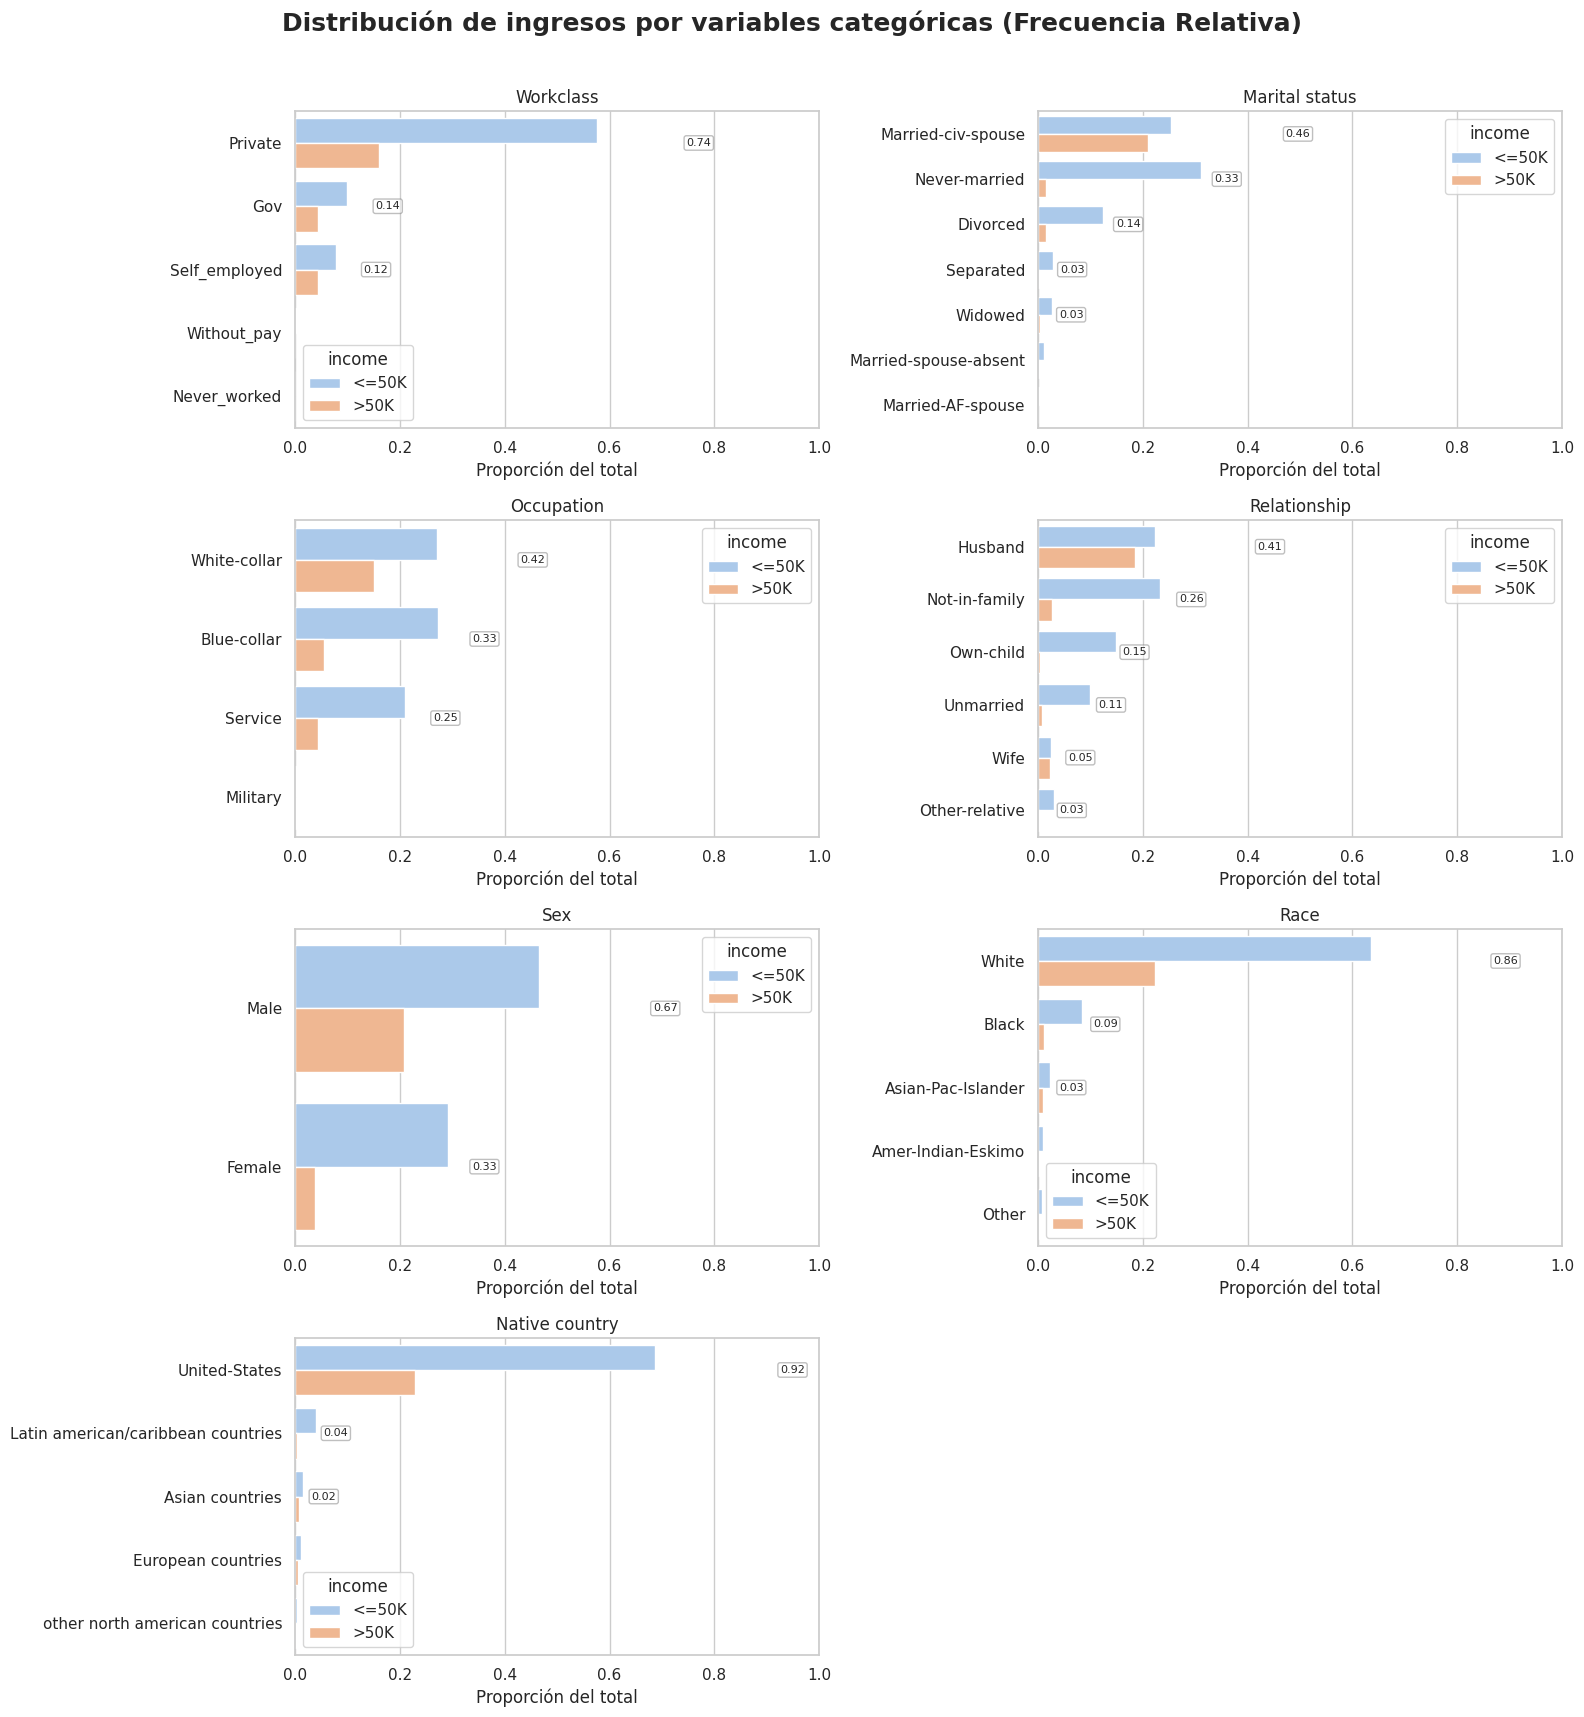

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Columnas categóricas a analizar
categoricas = ['workclass','marital_status', 'occupation',
               'relationship', 'sex', 'race', 'native_country']

sns.set_theme(style="whitegrid", palette="pastel")

def graficar_distribucion_por_categoria(df, columna, ax):
    # 1. Agrupar. Ahora 'income' tiene 0 y 1.
    conteo = df.groupby([columna, 'income']).size()

    # unstack() crea columnas 0 y 1. fillna(0) por si alguna categoría no tiene ambos
    porcentaje = (conteo / conteo.sum()).unstack().fillna(0)

    # 2. Renombrar columnas de 0/1 a texto solo para la leyenda del gráfico
    porcentaje.columns = ['<=50K', '>50K']

    porcentaje['total'] = porcentaje.sum(axis=1)
    porcentaje = porcentaje.sort_values('total', ascending=False)

    # 3. Preparar datos para seaborn
    df_barras = porcentaje[['<=50K', '>50K']].reset_index().melt(
        id_vars=columna,
        var_name='income',
        value_name='proporcion'
    )

    sns.barplot(
        data=df_barras,
        x='proporcion',
        y=columna,
        hue='income',
        ax=ax
    )

    ax.set_title(columna.replace('_', ' ').capitalize())
    ax.set_xlabel("Proporción del total")
    ax.set_ylabel("")
    ax.set_xlim(0, 1)

    # 4. Etiquetas de total corregidas
    for i, (nombre_cat, fila) in enumerate(porcentaje.iterrows()):
        total = fila['total']
        # Si la categoría representa más del 2% del dataset, ponemos la etiqueta
        if total > 0.02:
            ax.text(total + 0.01, i, f"{total:.2f}",
                    va='center', ha='left', fontsize=8,
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="gray", alpha=0.5))

# --- Crear subplots ---
n = len(categoricas)
fig, axes = plt.subplots(nrows=(n + 1) // 2, ncols=2, figsize=(16, n * 2.5))
axes = axes.flatten()

for i, col in enumerate(categoricas):
    graficar_distribucion_por_categoria(df, col, axes[i])

# Eliminar ejes sobrantes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Distribución de ingresos por variables categóricas (Frecuencia Relativa)", fontsize=18, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


**Observaciones Clave:**

- **`Marital Status` y `Relationship`**: Ser `Married-civ-spouse` (casado con
cónyuge civil) o `Husband`/`Wife` (esposo/esposa) muestra una proporción
significativamente mayor de individuos con ingresos >50K. Esto sugiere que la
estructura familiar y el estado civil son predictores muy fuertes.

- **`Occupation`**: Las ocupaciones `White-collar` (de cuello blanco) tienen la
mayor proporción de altos ingresos, validando la agrupación realizada.- **`Sex`**: Existe una disparidad notable, donde los hombres (`Male`) tienen una
proporción mucho mayor de ingresos altos en comparación con las mujeres (`Female`)

# Análisis de la variable Target - "income"

In [48]:
df

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,Gov,13,Never-married,White-collar,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self_employed,13,Married-civ-spouse,White-collar,Husband,White,Male,0,0,13,United-States,0
2,38,Private,9,Divorced,Blue-collar,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,7,Married-civ-spouse,Blue-collar,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,13,Married-civ-spouse,White-collar,Wife,Black,Female,0,0,40,Latin american/caribbean countries,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,13,Divorced,White-collar,Not-in-family,White,Female,0,0,36,United-States,0
48838,64,NaN,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States,0
48839,38,Private,13,Married-civ-spouse,White-collar,Husband,White,Male,0,0,50,United-States,0
48840,44,Private,13,Divorced,White-collar,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,0


In [49]:
df.income.unique()

array([0, 1])

## Análisis gráfico de target

Este paso es crucial para analizar la distribución de la variable objetivo y detectar
desbalances.

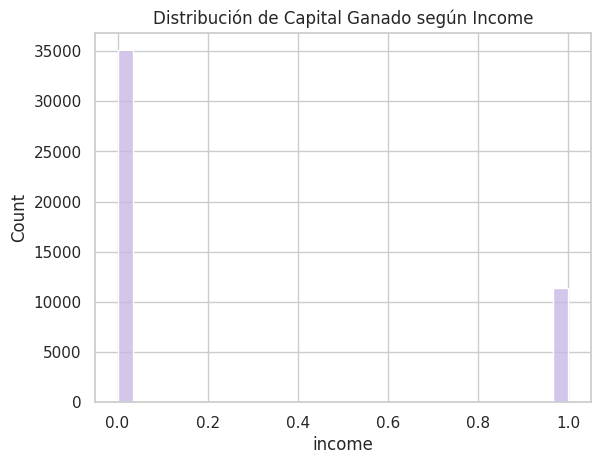

In [50]:
# Crear figura y eje
fig, ax = plt.subplots()

# Graficar histograma
sns.histplot(data=df, x='income', bins=30, kde=False, ax=ax, color='#C5B4E3')

# Título del gráfico
ax.set_title('Distribución de Capital Ganado según Income')

# Mostrar gráfico
plt.show()


In [51]:
round(((df['income']==0).mean()*100), 2)

np.float64(75.55)

In [52]:
round(((df['income']==1).mean()*100),2)

np.float64(24.45)

El dataset está significativamente desbalanceado: **75.6%** de los individuos ganan
`<=50K` y solo **24.4%** ganan `>50K`. Este es un **problema de clasificación
desbalanceada**.  

**Implicaciones:**

- **Métrica de Evaluación:** La `accuracy` no es una métrica fiable. Un modelo que
prediga siempre `<=50K` tendría un 75.6% de accuracy, pero sería inútil. Por ello,
nos centraremos en métricas como el **F1-Score**, **Precision**, **Recall** y el
**Área Bajo la Curva ROC (AUC)**.

- **Técnica de Mitigación:** Para evitar que el modelo se incline hacia la clase
mayoritaria, se utilizará la técnica **SMOTE (Synthetic Minority Over-sampling
Technique)** dentro del pipeline de entrenamiento para generar ejemplos sintéticos
de la clase minoritaria.

# Análisis de Correlación


Se analiza la relación entre las variables para detectar multicolinealidad (entre
predictoras) y la fuerza de la relación con la variable objetivo.

## Correlación Spearson - variables numéricas

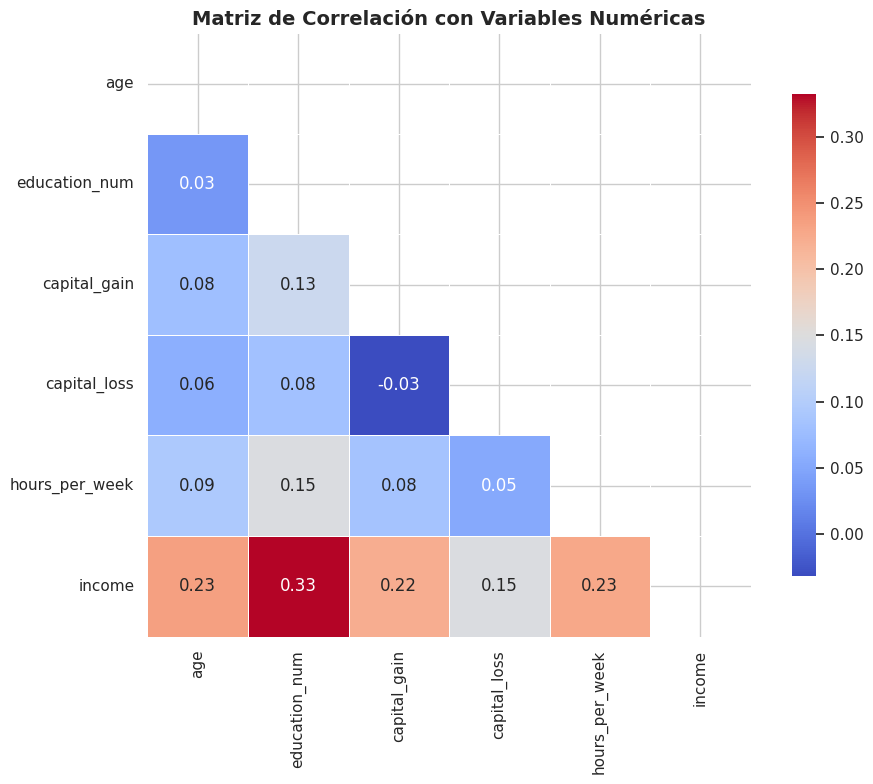

In [53]:
df_corr = df.copy()

numericas_con_target = df_corr.select_dtypes(include=['int64', 'float64'])

corr = numericas_con_target.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

# Graficar heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", mask=mask, square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title("Matriz de Correlación con Variables Numéricas", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()


## Correlación Cramér's V - variables categóricas

In [54]:
from scipy.stats import chi2_contingency #permite hacer un especie de correlación de las variables categóricas

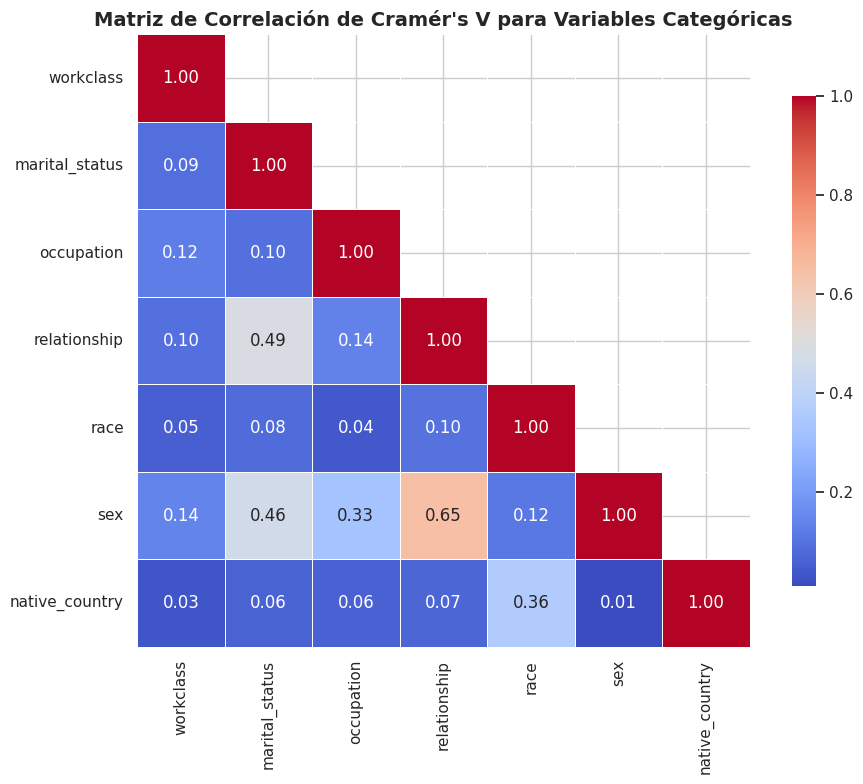

In [55]:
# Función para calcular Cramér's V
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

categoricas = df.select_dtypes(include=['object']).columns

# Crear una matriz de correlación de Cramér's V
cramers_v_matrix = pd.DataFrame(np.zeros((len(categoricas), len(categoricas))), columns=categoricas, index=categoricas)

# Calcular Cramér's V para todas las combinaciones de variables categóricas
for col1 in categoricas:
    for col2 in categoricas:
        cramers_v_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])


for i in range(len(categoricas)):
    for j in range(i+1, len(categoricas)):
        cramers_v_matrix.iloc[i, j] = np.nan

# Graficar el heatmap de Cramér's V
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_matrix.astype(float), annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title("Matriz de Correlación de Cramér's V para Variables Categóricas", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()



## **Conclusiones del Análisis de Correlación:**

- **Variables Predictoras vs. `income`**: La matriz de Pearson muestra que
`education_num` (0.34), `age` (0.23), `hours_per_week` (0.23) y `capital_gain`
(0.22) tienen una correlación positiva de débil a moderada con el `income`, lo que
**respalda nuestra hipótesis inicial**.

- **Multicolinealidad**: No se observa multicolinealidad severa entre las variables
predictoras. En las categóricas, `relationship` y `marital_status` (V de Cramér =
0.65) muestran una asociación fuerte, lo cual es lógicamente esperado, pero no
problemático para los modelos basados en árboles que utilizaremos (como Random
Forest y XGBoost). Por lo tanto, conservaremos todas las variables.

# División de datos y pipelines de preprocesamiento

## División de datos para test y para entrenamiento

In [56]:
X = df.drop(columns='income').copy()
y = df['income'].copy()

In [57]:
from sklearn.model_selection import train_test_split

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Pipeline de preprocesamiento


Para asegurar la consistencia y reproducibilidad, encapsulamos todo el proceso de
preprocesamiento en un `Pipeline` de Scikit-Learn. Esto previene la fuga de datos
(data leakage) y simplifica el flujo de trabajo.

In [59]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [60]:
nominals_columns = X.select_dtypes(include='object').columns.tolist()
numeric_columns = X.select_dtypes(include=['int64']).drop(columns=nominals_columns, errors='ignore').columns.tolist()

In [61]:
nominals_columns, numeric_columns #control de la selecciòn de columnas

(['workclass',
  'marital_status',
  'occupation',
  'relationship',
  'race',
  'sex',
  'native_country'],
 ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week'])

In [62]:
# pipeline para preprocesamiento de columnas naturalmente categoricas categoricas nominales
nominal_pipe = Pipeline(
    [
    ('oh_enc', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop= 'if_binary')),
    ('scaler', RobustScaler())
]
    )

# pipeline para preprocesamiento de columnas naturalmente categoricas categoricas ordinales

# pipeline para preprocesamiento de columnas naturalmente numericas
numeric_pipe = Pipeline(
    [
    ('scaler', RobustScaler())
]
    )

In [63]:
#hacer el ColumnTransformer
columns_transform= ColumnTransformer(
    [
        ('nominal_CTrans', nominal_pipe, nominals_columns),
        ('numeric_CTrans', numeric_pipe, numeric_columns)
    ]
)

In [64]:
columns_transform

ColumnTransformer(transformers=[('nominal_CTrans',
                                 Pipeline(steps=[('oh_enc',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False)),
                                                 ('scaler', RobustScaler())]),
                                 ['workclass', 'marital_status', 'occupation',
                                  'relationship', 'race', 'sex',
                                  'native_country']),
                                ('numeric_CTrans',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['age', 'education_num', 'capital_gain',
                                  'capital_loss', 'hours_per_week'])])

# Pipeline de entrenamiento y selección del mejor modelo

Se evaluarán cuatro algoritmos de clasificación populares para identificar el de
mejor rendimiento para este problema:- Decision Tree- K-Nearest Neighbors (KNN)- Random Forest- XGBoost

In [65]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

In [66]:
#pipeline para DecisionTreeClassifier
pipe_Tree = imbPipeline(
    [
        ('columns_transform', columns_transform),
        ('smote', SMOTE(random_state=42)), #PAra que balancee la cantidad de >50K
        ('tree_model', DecisionTreeClassifier(random_state=42))
    ]
)

#pipeline para KNeighborsClassifier
pipe_KNN = imbPipeline(
    [
        ('columns_transform', columns_transform),
        ('smote', SMOTE(random_state=42)), #PAra que balancee la cantidad de >50K
        ('KNN_model', KNeighborsClassifier())
    ]
)

#pipeline para RandomForestClassifier
pipe_RF = imbPipeline(
    [
        ('columns_transform', columns_transform),
        ('smote', SMOTE(random_state=42)), #PAra que balancee la cantidad de >50K
        ('RF_model', RandomForestClassifier(random_state=42))
    ]
)

#pipeline para XGBoost

pipe_XGB = imbPipeline(
    [
        ('columns_transform', columns_transform),
        ('smote', SMOTE(random_state=42)), #PAra que balancee la cantidad de >50K
        ('XGB_model', XGBClassifier(random_state=42))
    ]
)

Utilizaremos `GridSearchCV` con validación cruzada de 5 folds para encontrar los
hiperparámetros óptimos para cada modelo, utilizando el **F1-Score** como métrica
de optimización debido al desbalance de clases

In [67]:
# Diccionario de modelos
modelos = {
    'Decision Tree': pipe_Tree,
    'KNN': pipe_KNN,
    'Random Forest': pipe_RF,
    'XGBoost': pipe_XGB
}

In [68]:
#hacer GridSearch para ver mejores modelos y parametros
from sklearn.model_selection import GridSearchCV

In [69]:
#Diccionario para probar los parametros de cada modelo
param_grid = {
    'Decision Tree': {
        'tree_model__max_depth': [3, 5, 7, 9, 11, 13, 15, 17],
        'tree_model__criterion': ['gini', 'entropy']
    },
    'KNN': {
        'KNN_model__n_neighbors': [5, 7, 9, 11, 13, 15, 17],
        'KNN_model__weights': ['uniform', 'distance']
    },
    'Random Forest': {
        'RF_model__n_estimators': [50, 100, 200, 300, 500],
        'RF_model__max_depth': [3, 5, 7, 9, 11, 13, 15, 17]
    },

    'XGBoost': {
        'XGB_model__n_estimators': [50, 100, 200, 300, 500],
        'XGB_model__max_depth': [3, 5, 7, 9, 11, 13, 15, 17]
    }
}

In [70]:
df

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,Gov,13,Never-married,White-collar,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self_employed,13,Married-civ-spouse,White-collar,Husband,White,Male,0,0,13,United-States,0
2,38,Private,9,Divorced,Blue-collar,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,7,Married-civ-spouse,Blue-collar,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,13,Married-civ-spouse,White-collar,Wife,Black,Female,0,0,40,Latin american/caribbean countries,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,13,Divorced,White-collar,Not-in-family,White,Female,0,0,36,United-States,0
48838,64,NaN,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States,0
48839,38,Private,13,Married-civ-spouse,White-collar,Husband,White,Male,0,0,50,United-States,0
48840,44,Private,13,Divorced,White-collar,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,0


In [71]:
#Loop para ver el mejor estimador y parámetros

resultados = []

for nombre, pipe in modelos.items():
    print(f"Buscando hiperparámetros para {nombre}...")
    grid = GridSearchCV(
        pipe,
        param_grid[nombre],
        cv=5,
        scoring='f1',
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    resultados.append({
        'modelo': nombre,
        'mejor_f1': grid.best_score_,
        'mejor_pipeline': grid.best_estimator_,
        'mejores_parametros': grid.best_params_
    })

Buscando hiperparámetros para Decision Tree...
Buscando hiperparámetros para KNN...
Buscando hiperparámetros para Random Forest...
Buscando hiperparámetros para XGBoost...


In [72]:
#mejores parametros para cada modelo
for r in resultados:
    print(f"\nModelo: {r['modelo']}")
    print(f"Mejor F1: {r['mejor_f1']:.3f}")
    print(f"Mejores parámetros: {r['mejores_parametros']}")


Modelo: Decision Tree
Mejor F1: 0.680
Mejores parámetros: {'tree_model__criterion': 'gini', 'tree_model__max_depth': 11}

Modelo: KNN
Mejor F1: 0.685
Mejores parámetros: {'KNN_model__n_neighbors': 13, 'KNN_model__weights': 'uniform'}

Modelo: Random Forest
Mejor F1: 0.694
Mejores parámetros: {'RF_model__max_depth': 17, 'RF_model__n_estimators': 200}

Modelo: XGBoost
Mejor F1: 0.717
Mejores parámetros: {'XGB_model__max_depth': 3, 'XGB_model__n_estimators': 300}


In [73]:
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by='mejor_f1', ascending=False)

# Mostrar todos los resultados ordenados
print(df_resultados)

# Mostrar el mejor modelo
mejor_modelo = df_resultados.iloc[0]
print("\n Mejor modelo según F1:")
print(f"Modelo: {mejor_modelo['modelo']}")
print(f"Score: {mejor_modelo['mejor_f1']:.4f}")
print(f"Mejores parámetros: {mejor_modelo['mejores_parametros']}")

          modelo  mejor_f1                                     mejor_pipeline  \
3        XGBoost  0.716938  (ColumnTransformer(transformers=[('nominal_CTr...   
2  Random Forest  0.693675  (ColumnTransformer(transformers=[('nominal_CTr...   
1            KNN  0.684803  (ColumnTransformer(transformers=[('nominal_CTr...   
0  Decision Tree  0.679597  (ColumnTransformer(transformers=[('nominal_CTr...   

                                  mejores_parametros  
3  {'XGB_model__max_depth': 3, 'XGB_model__n_esti...  
2  {'RF_model__max_depth': 17, 'RF_model__n_estim...  
1  {'KNN_model__n_neighbors': 13, 'KNN_model__wei...  
0  {'tree_model__criterion': 'gini', 'tree_model_...  

 Mejor modelo según F1:
Modelo: XGBoost
Score: 0.7169
Mejores parámetros: {'XGB_model__max_depth': 3, 'XGB_model__n_estimators': 300}


## **Conclusión de la Selección de Modelo:**  

El modelo **XGBoost** emerge como el claro ganador, alcanzando el F1-Score más alto
(0.715) en la validación cruzada. Esto indica su superioridad para manejar la
complejidad inherente de los datos y el desbalance de clases. Por lo tanto, se
selecciona XGBoost con sus hiperparámetros óptimos para la fase final de
evaluación

#  Evaluación del Modelo Final (XGBoost)


Ahora, entrenamos el pipeline de XGBoost con los mejores hiperparámetros
encontrados en todo el conjunto de entrenamiento y lo evaluamos en el conjunto de
prueba, que el modelo no ha visto nunca.

In [74]:
Final_pipe_XGB = imbPipeline(
    [
        ('columns_transform', columns_transform),
        ('smote', SMOTE(random_state=42)), #PAra que balancee la cantidad de >50K
        ('XGB_model', XGBClassifier(max_depth=3, n_estimators=300, random_state=42, n_jobs=-1))
    ]
)

In [75]:
Final_pipe_XGB.fit(X_train, y_train)

Pipeline(steps=[('columns_transform',
                 ColumnTransformer(transformers=[('nominal_CTrans',
                                                  Pipeline(steps=[('oh_enc',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['workclass',
                                                   'marital_status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native_country']),
                                                 ('numeric_CTrans',
                                                  Pipeline(steps=[('scaler...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [76]:
y_train_pred= Final_pipe_XGB.predict(X_train)
y_test_pred= Final_pipe_XGB.predict(X_test)

###Análisis de eficiencia del modelo: Arcuraccy, reporte y matriz de confusión

In [77]:
acc=Final_pipe_XGB.score(X_train, y_train)
print(f'Accuracy: {acc}')

Accuracy: 0.8570813371373204


In [78]:
from sklearn.metrics import classification_report

In [97]:
print('metricas para test')
print(classification_report(y_train, y_train_pred, digits= 3))
print(classification_report(y_test, y_test_pred, digits= 3))


metricas para test
              precision    recall  f1-score   support

           0      0.931     0.876     0.903     28071
           1      0.675     0.800     0.732      9083

    accuracy                          0.857     37154
   macro avg      0.803     0.838     0.817     37154
weighted avg      0.869     0.857     0.861     37154

              precision    recall  f1-score   support

           0      0.927     0.876     0.901      7018
           1      0.673     0.788     0.726      2271

    accuracy                          0.854      9289
   macro avg      0.800     0.832     0.813      9289
weighted avg      0.865     0.854     0.858      9289



**Análisis del Rendimiento:**

- **Generalización:** El rendimiento en el conjunto de entrenamiento y de prueba es
muy similar (e.g., F1-score de 0.73 vs 0.72 para la clase 1). Esto es una excelente
señal de que **el modelo generaliza bien y no sufre de sobreajuste (overfitting)**.

- **Clase 1 (>50K):** El modelo logra un `recall` de 0.78, lo que significa que
identifica correctamente al 78% de todas las personas que realmente ganan más de
50K. Su `precision` de 0.68 indica que del total de personas que predice como de
altos ingresos, el 68% son aciertos. El **F1-Score de 0.72** es un buen balance
entre ambas métricas para la clase minoritaria.

- **Clase 0 (<=50K):** El modelo es extremadamente preciso (0.90) y robusto (recall
de 0.88) para la clase mayoritaria.

## Importancia de las Características


Analizar la importancia de las características nos permite entender qué variables
influyeron más en las predicciones del modelo, añadiendo una capa crucial de
interpretabilidad.

In [80]:
# Obtener nombres de las features después de la transformación
feature_names = Final_pipe_XGB.named_steps["columns_transform"].get_feature_names_out()

# Crear DataFrame con importancias
fi = pd.DataFrame({
    "FEATURE": feature_names,
    "IMPORTANCE": Final_pipe_XGB.named_steps["XGB_model"].feature_importances_
})

# Ordenar por importancia
fi = fi.sort_values("IMPORTANCE", ascending=False)
fi

,FEATURE,IMPORTANCE
8,nominal_CTrans__marital_status_Married-civ-spouse,0.419072
16,nominal_CTrans__occupation_White-collar,0.068332
37,numeric_CTrans__education_num,0.046140
38,numeric_CTrans__capital_gain,0.041147
28,nominal_CTrans__race_White,0.039571
21,nominal_CTrans__relationship_Own-child,0.033772
29,nominal_CTrans__sex_Male,0.033278
32,nominal_CTrans__native_country_Latin american/...,0.028650
33,nominal_CTrans__native_country_United-States,0.024025
23,nominal_CTrans__relationship_Wife,0.022017


/tmp/ipython-input-1254919494.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="IMPORTANCE", y="FEATURE", data=fi, palette="pastel")


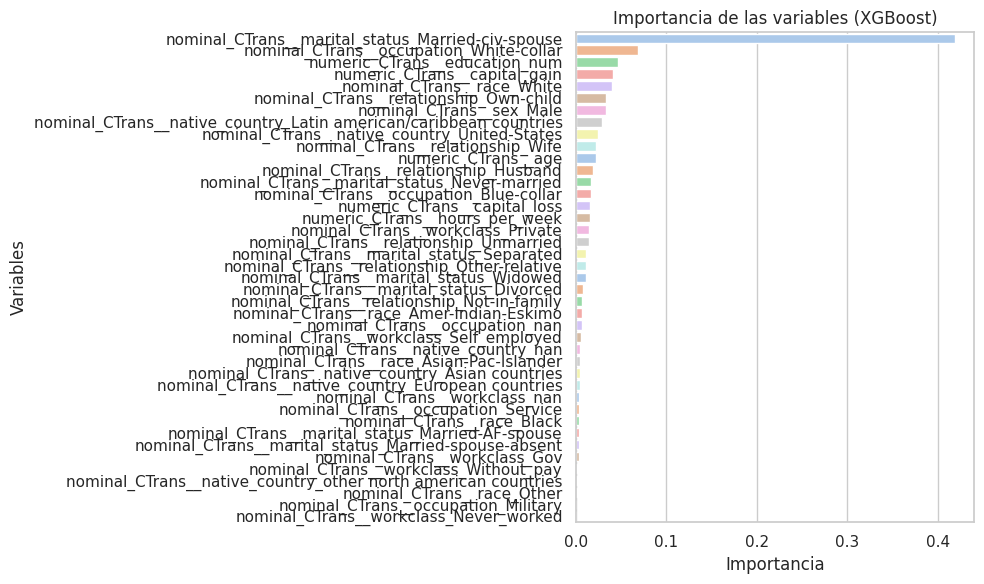

In [81]:
plt.figure(figsize=(10, 6))
sns.barplot(x="IMPORTANCE", y="FEATURE", data=fi, palette="pastel")
plt.title("Importancia de las variables (XGBoost)")
plt.xlabel("Importancia")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()

Como se esperaba, `marital_status_Married-civ-spouse` es, con diferencia, la
característica más predictiva. Esto confirma que el estado civil es un factor
determinante del nivel de ingresos en este dataset. Otras variables importantes
como `education_num` y `capital_gain` también validan nuestra hipótesis inicial.

##  Análisis de la Matriz de Confusión

In [82]:
from sklearn.metrics import confusion_matrix

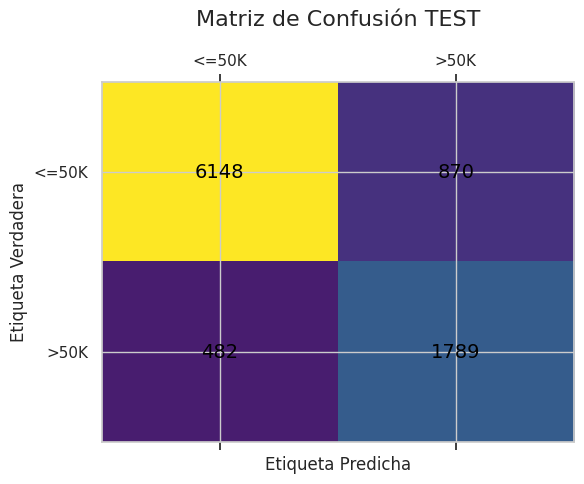

In [83]:
# Crear la matriz de confusión para el test
cm = confusion_matrix(y_test, y_test_pred)

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(6, 5))
cax = ax.matshow(cm, cmap='viridis', interpolation='nearest', aspect='auto', vmin=0)

# Títulos y etiquetas
plt.title('Matriz de Confusión TEST', fontsize=16, pad=20)
ax.set_xlabel('Etiqueta Predicha', fontsize=12)
ax.set_ylabel('Etiqueta Verdadera', fontsize=12)
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['<=50K', '>50K'])
ax.set_yticklabels(['<=50K', '>50K'])

# Anotar cada celda con su valor
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', fontsize=14, color='black')


plt.tight_layout()
plt.show()

La matriz de confusión visualiza los resultados:

- **Verdaderos Positivos (1789):** Individuos de altos ingresos correctamente
identificados.- **Falsos Negativos (482):** Individuos de altos ingresos incorrectamente
clasificados como de bajos ingresos (Error Tipo II).

- **Falsos Positivos (870):** Individuos de bajos ingresos incorrectamente
clasificados como de altos ingresos (Error Tipo I)

## Curva ROC


La curva ROC (Receiver Operating Characteristic) y el área bajo la curva (AUC) son
métricas clave para evaluar la capacidad de un modelo para discriminar entre
clases.

In [84]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [85]:
# predicción probabilistia, almacenando en y_score
y_score = Final_pipe_XGB.predict_proba(X_test)

In [86]:
y_score

array([[0.9978768 , 0.0021232 ],
       [0.99883354, 0.00116648],
       [0.9980831 , 0.00191689],
       ...,
       [0.5857375 , 0.41426247],
       [0.8447129 , 0.15528707],
       [0.63042676, 0.36957327]], dtype=float32)

In [87]:
# selección del segundo vecotr con las probabilidades para la clase positiva
y_score = y_score[:, 1]

In [88]:
y_score

array([0.0021232 , 0.00116648, 0.00191689, ..., 0.41426247, 0.15528707,
       0.36957327], dtype=float32)

In [89]:
# Compute ROC curve: fpr, tpr, thresholds
fpr,tpr,thresholds = roc_curve(y_true=y_test, y_score=y_score)
fpr,tpr,thresholds


(array([0.        , 0.        , 0.        , ..., 0.99786264, 0.99814762,
        1.        ]),
 array([0.00000000e+00, 4.40334654e-04, 6.16468516e-03, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 array([          inf, 9.9993479e-01, 9.9985301e-01, ..., 1.1180075e-05,
        1.0978211e-05, 2.0942380e-06], dtype=float32))

In [90]:
# calculo de roc_auc con FPR y TPR
auc(x=fpr, y=tpr)

np.float64(0.9259447838664594)

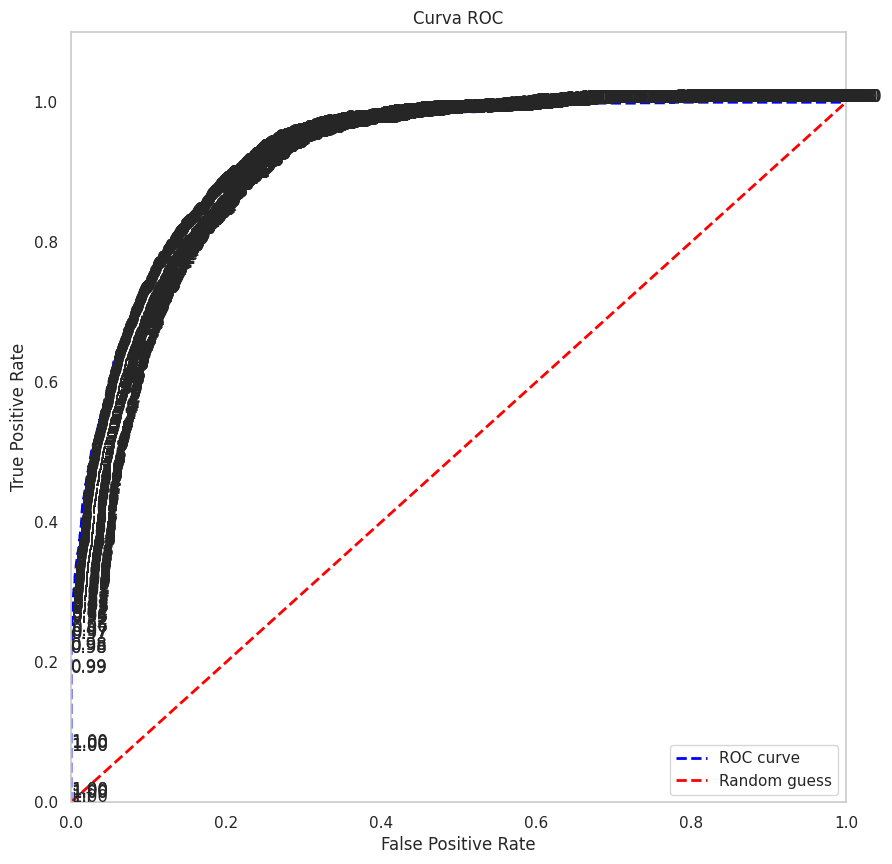

In [91]:
#Garaficamos curva ROC
plt.figure(figsize=(10, 10))
# ejes xlim e ylim
plt.xlim([0, 1])
plt.ylim([0, 1.1])
# grafica

# curva ROC
plt.plot(fpr, tpr, color='blue', linestyle= '--', lw=2, label='ROC curve')
# linea diagonal
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random guess')
# etiquetas para los ejes
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# leyenda
plt.legend(loc='lower right')
# titulo
plt.title('Curva ROC')

# Mostrar algunos umbrales como anotaciones
for i in range(len(thresholds)):
    plt.annotate(f'{thresholds[i]:.2f}', (fpr[i], tpr[i]))

plt.grid()
plt.show()

Un **AUC de 0.93** es un resultado excelente. Indica que el modelo tiene una gran
capacidad para distinguir entre individuos de altos y bajos ingresos. Si se
eligiera un individuo al azar de cada clase, hay un 93% de probabilidad de que el
modelo asigne una probabilidad más alta al individuo de altos ingresos.

## Análisis del Umbral de Decisión

El umbral por defecto para la clasificación es 0.5. Sin embargo, este umbral puede
no ser óptimo. Utilizando el **Índice de Youden**, podemos encontrar un umbral que
maximice la diferencia entre la Tasa de Verdaderos Positivos y la Tasa de Falsos
Positivos, buscando un equilibrio ideal.

In [92]:
#Seleccionando el mejor umbral según la formula de 'Yuden':
def yuden_best_threshold(fpr: np.array, tpr: np.array, thresholds: np.array) -> float:
    '''
    This function receives false positive rates, true positive rates and thresholds,
    calculates and returns the best threshold according to the Youden index.

    Args:
    - fpr (np.array): Array of false positive rates.
    - tpr (np.array): Array of true positive rates.
    - thresholds (np.array): Array of thresholds.

    Returns:
    - best_threshold (float): Best threshold based on Youden index.
    '''

    yuden_index = tpr - fpr
    best_yuden_index = np.argmax(yuden_index)
    best_threshold = thresholds[best_yuden_index]

    return best_threshold

In [93]:
# calculo del mejor umbral
yuden_best_threshold (fpr=fpr, tpr=tpr, thresholds=thresholds)
best_threshold = yuden_best_threshold (fpr=fpr, tpr=tpr, thresholds=thresholds)
best_threshold

np.float32(0.3250727)

In [94]:
# remplazando clases según umbral
y_pred =np.where(y_score > yuden_best_threshold(fpr=fpr, tpr=tpr, thresholds=thresholds), 1, 0)

In [95]:
# reporte de clasificación
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.80      0.87      7018
           1       0.59      0.89      0.71      2271

    accuracy                           0.82      9289
   macro avg       0.77      0.84      0.79      9289
weighted avg       0.87      0.82      0.83      9289



### **Discusión Estratégica sobre el Umbral:**

- **Modelo con Umbral por Defecto (0.5):** `Precision: 0.68`, `Recall: 0.78`, `F1
score: 0.72`

- **Modelo con Umbral de Youden (0.31):** `Precision: 0.58`, `Recall: 0.90`, `F1
score: 0.71`
Al ajustar el umbral, logramos un **aumento significativo en el Recall** (de 0.78 a
0.90), lo que significa que el modelo ahora identifica al 90% de los verdaderos
positivos. Sin embargo, esto ocurre a costa de una **menor Precisión** (de 0.68 a
0.58), aumentando los falsos positivos.
La elección del umbral depende del objetivo de negocio:  
  
==========================================================================================

**Priorizar Precisión (Minimizar Falsos Positivos):** Si el costo de un falso
positivo es alto (ej. lanzar una campaña de marketing de lujo muy costosa), el
umbral por defecto (0.5) es preferible.  

**Priorizar Recall (Minimizar Falsos Negativos):** Si el costo de un falso
negativo es alto (ej. no identificar a un cliente de alto valor potencial), el
umbral de Youden es mejor.  

==========================================================================================

Para un modelo de propósito general, el **umbral por defecto ofrece un F1-score
ligeramente superior y un mejor equilibrio**, por lo que se considera la opción
principal.

##Conclusion final


Este proyecto logró con éxito el objetivo de desarrollar un modelo de Machine
Learning robusto y de alto rendimiento para predecir si los ingresos de un
individuo superan los $50K anuales.
**Hallazgos Clave:**
1. **Confirmación de la Hipótesis:** El análisis confirmó que variables
socioeconómicas como el estado civil (`marital_status`), el nivel educativo
(`education_num`) y las ganancias de capital (`capital_gain`) son predictores
fundamentales del nivel de ingresos, siendo el estado civil de casado el factor de
mayor peso.
2. **Selección del Modelo:** El algoritmo **XGBoost demostró ser el más eficaz**,
superando a otros modelos como Random Forest, KNN y Decision Tree, con un **F1
Score de 0.72** en la clase minoritaria y un **AUC de 0.93** en el conjunto de
prueba.
3. **Rendimiento y Generalización:** El modelo final no muestra signos de
sobreajuste, ya que su rendimiento es consistente entre los datos de entrenamiento
y de prueba. Esto indica que ha aprendido patrones generalizables del dataset.
4. **Manejo del Desbalance:** La estrategia de sobremuestreo con **SMOTE** fue
crucial para entrenar un modelo capaz de identificar correctamente a la clase
minoritaria (altos ingresos), logrando un excelente recall de 0.78.  

**Aplicaciones Potenciales:**
El pipeline desarrollado es una herramienta poderosa que podría ser aplicada en
diversos contextos de negocio, como:
  - **Segmentación de Clientes:** Identificar clientes con alto poder adquisitivo
para campañas de marketing personalizadas.

  - **Evaluación de Riesgo Crediticio:** Como una característica adicional en modelos
de scoring de crédito.
  
  - **Estudios Socioeconómicos:** Analizar los factores que impulsan la disparidad de
ingresos en diferentes demografías.

**Próximos Pasos:**

  - **Despliegue:** El pipeline final puede ser fácilmente serializado (con `joblib`
o `pickle`) y desplegado como un servicio API (ej. usando FastAPI o Flask) para
realizar predicciones en tiempo real.
  - **Monitoreo y Mantenimiento:** Una vez en producción, sería esencial monitorear
el rendimiento del modelo a lo largo del tiempo (Model Drift) y re-entrenarlo
periódicamente con nuevos datos

#---------FIN----------#